# Classifier for MNIST for FreeNN experiments

- v0: Implementation close to what exists online

# I. Loading and visualizing MNIST

## I.1. Declarations and dataset loaders

In [61]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import math

# Dimension of output space  = number of classes
Z_DIM = 10
# batch size
bs = 256
# Number of workers in DataLoader
num_workers = 10
# Train epochs
num_epochs = 10
# In MNIST, images are 28x28 pixels
MNIST_SIZE = 28
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset  = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True)

## I.2. Plotting

Dimensions of input:  torch.Size([256, 1, 28, 28])
Plot of batch: 


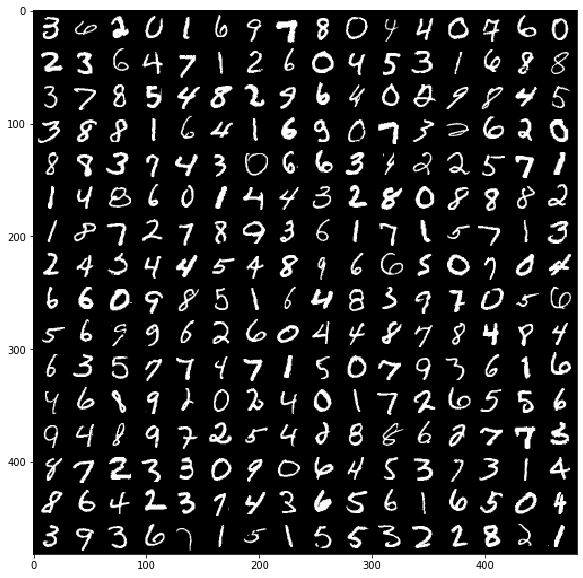

Classes: 
    3     6     2     0     1     6     9     7     8     0     4     4     0     7     6     0
    2     3     6     4     7     1     2     6     0     4     5     3     1     6     8     8
    3     7     8     5     4     8     2     9     6     4     0     2     9     8     4     5
    3     8     8     1     6     4     1     6     9     0     7     3     2     6     2     0
    8     8     3     7     4     3     0     6     6     3     4     2     2     5     7     1
    1     4     8     6     0     1     4     4     3     2     8     0     8     8     8     2
    1     8     7     2     7     8     9     3     6     1     7     1     5     7     1     3
    2     4     3     4     4     5     4     8     9     6     6     5     0     7     0     4
    6     6     0     9     8     5     1     6     4     8     3     9     7     0     5     6
    5     6     9     9     6     2     6     0     4     4     8     7     8     4     8     4
    6     3     5     7     7 

In [62]:
# Plot
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# functions to show an image
def imshow(img):
  plt.rcParams['figure.figsize'] = [10, 10]
  # Mnist does not need normalization
  # img = img / 2 + 0.5     # unnormalize
  count = img.shape[0]
  nrow = int( np.sqrt(count) )
  img = torchvision.utils.make_grid(img, nrow=nrow)
  npimg = img.numpy()
  npimg = np.transpose(npimg, (1, 2, 0))
  plt.imshow(npimg)
  plt.show()


# get some random training images (First batch)
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show dim
print( "Dimensions of input: ", images.shape )
# show images
print( "Plot of batch: " )
imshow(images)
# print labels
classes = [ str(i) for i in range(10)]
nrow = int( np.sqrt(bs) )
print('Classes: ' )
for l in range(nrow):
  print(' '.join('%5s' % classes[labels[j+nrow*l]] for j in range(nrow)))

# II. ML

## II.1. Definition of the neural net

In [63]:
class Net(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(Net, self).__init__()
        # Non-linearity
        self.non_linearity = torch.sin
        # Classifier
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc3 = nn.Linear(h_dim2, z_dim)
        
    def forward(self, x):
        h = x.view(-1, MNIST_SIZE*MNIST_SIZE)
        h = self.non_linearity(self.fc1(h))
        h = self.non_linearity(self.fc2(h))
        z = self.fc3(h)
        return z

# build model
classifier = Net(x_dim=MNIST_SIZE*MNIST_SIZE, h_dim1= 512, h_dim2=256, z_dim=Z_DIM)
if torch.cuda.is_available():
    classifier.cuda()

In [64]:
print(classifier)

print( "Parameters: %d"%len([ x for x in classifier.parameters()]) )
for param in classifier.parameters():
  print(type(param.data), param.size())

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)
Parameters: 6
<class 'torch.Tensor'> torch.Size([512, 784])
<class 'torch.Tensor'> torch.Size([512])
<class 'torch.Tensor'> torch.Size([256, 512])
<class 'torch.Tensor'> torch.Size([256])
<class 'torch.Tensor'> torch.Size([10, 256])
<class 'torch.Tensor'> torch.Size([10])


## II.2. Optimizer and loss functions

In [65]:
optimizer = optim.Adam(classifier.parameters())
    
# Loss = Binary Cross Entropy
# Inputs:
#   data: original data
#   z: latent variable
def loss_function(predictions, labels):
    return 1e4*F.cross_entropy(predictions, labels, reduction='mean')

In [66]:
from tqdm import tqdm_notebook as tqdm

log_loss     = []
log_accuracy = []

def accuracy_batch(predictions, labels):
    predicted_classes = torch.argmax(predictions, dim=1)
    return torch.mean((predicted_classes == labels).float())

def train(epoch):
    classifier.train()
    train_loss = 0
    print("Epoch %d"%epoch)
    t = tqdm( train_loader, position=0 )
    for (data, labels) in t:
        data   = data.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        # Forward
        predictions = classifier(data)
        loss = loss_function(predictions, labels)
        # Backpropagate
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        # Logging
        log_loss.append( loss.item() )
        log_accuracy.append( accuracy_batch(predictions, labels) )
        # Progress bar
        t.set_description_str(desc="Average train loss: %.6f"% (train_loss / len(train_loader.dataset)) )
    # end for
    return train_loss

def test():
    classifier.eval()
    test_loss= 0
    with torch.no_grad():
        t = tqdm( test_loader, desc="Test", position=1 )
        for data, labels in t:
            data   = data.cuda()
            labels = labels.cuda()
            predictions = classifier(data)
            # sum up batch loss
            test_loss += loss_function(predictions, labels).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Total test set loss: {:.4f}'.format(test_loss))
    print("")
    return test_loss

## II. 3. Train loop

In [67]:
# Launch
loss_history = []
for epoch in range(1, num_epochs):
  train_loss = train(epoch)
  test_loss  = test()
  loss_history.append(train_loss)

Epoch 1



====> Total test set loss: 6.6915

Epoch 2



====> Total test set loss: 3.9915

Epoch 3



====> Total test set loss: 3.4021

Epoch 4



====> Total test set loss: 2.8696

Epoch 5



====> Total test set loss: 2.7822

Epoch 6



====> Total test set loss: 2.3748

Epoch 7



====> Total test set loss: 2.6059

Epoch 8



====> Total test set loss: 2.4907

Epoch 9



====> Total test set loss: 2.2614



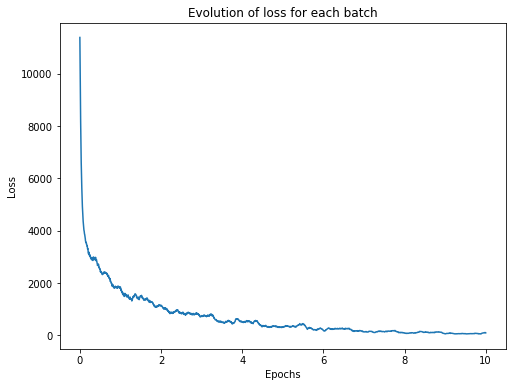

In [68]:
# Form mobile average over window of size N
# That is to say, N batches
N = 20
average_loss = np.convolve(log_loss, np.ones((N,))/N)[(N-1):-N]
time = np.linspace(0, num_epochs, len(average_loss) )

# Log
plt.figure(figsize=(8, 6))
plt.title('Evolution of loss for each batch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot( time, average_loss )
axes = plt.gca()


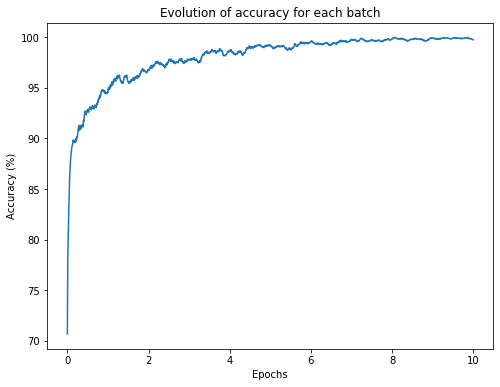

In [71]:
# Form mobile average over window of size N
# That is to say, N batches
N = 20
average_accuracy = np.convolve(log_accuracy, np.ones((N,))/N)[(N-1):-N]
time = np.linspace(0, num_epochs, len(average_accuracy) )

# Log
plt.figure(figsize=(8, 6))
plt.title('Evolution of accuracy for each batch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.plot( time, average_accuracy*100 )
axes = plt.gca()